In [1]:
import math
import os
import time
import json
from pathlib import Path
from typing import Literal, Optional

import numpy as np
import torch
from PIL import Image
from torch import Tensor, optim

from gsplat import rasterization, rasterization_2dgs
from dataclasses import dataclass, field
from typing import Dict, List, Optional, Tuple, Union
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
import matplotlib.pyplot as plt
import os
from IPython.display import display, clear_output
import torch.nn.functional as F
from diffusers import DiffusionPipeline

/home/nskochetkov/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [31]:
@dataclass
class Config:
    width: int = 256
    height: int = 256
    num_points: int = 100_000
    save_imgs: bool = True
    iterations: int = 1_000
    lr: float = 0.01
    model_type: Literal["3dgs", "2dgs"] = "3dgs"
    save_steps: List[int] = field(default_factory=lambda: [7_000, 30_000])
    img_path: str = ""
    ckpt_path: str = ""
    results_dir: str = "results_2d"
    show_steps: int = 10
    use_sds_loss: bool = False
    use_fused_loss: bool = False
    lmbd : float = 1.0
    save_images: bool = False
    patch_image: bool = False

In [32]:
class SDSLoss3DGS(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # load the model
        self.device = torch.device("cuda:0")

        # this is to make it work on the cluster as it does not have internet access to download the model
        deepfloyd_sr_model_path = "/home/nskochetkov/.cache/huggingface/hub/models--DeepFloyd--IF-II-L-v1.0/snapshots/609476ce702b2d94aff7d1f944dcc54d4f972901"
        pipe = DiffusionPipeline.from_pretrained(
            deepfloyd_sr_model_path,
            # text_encoder=None,
            safety_checker=None,
            watermarker=None,
            feature_extractor=None,
            requires_safety_checker=False,
            variant="fp16",
            torch_dtype=torch.float16,
        ).to(self.device)

        self.unet = pipe.unet.eval()
        self.scheduler = pipe.scheduler
        self.num_train_timesteps = self.scheduler.config.num_train_timesteps
        self.alphas = self.scheduler.alphas_cumprod.to(self.device)
        self.prompt_embeddings = pipe.encode_prompt("")

    @torch.amp.autocast("cuda", enabled=False)
    def forward_unet(self, latents, t, encoder_hidden_states, **kwargs):
        input_dtype = latents.dtype
        return self.unet(
            latents.to(torch.float16),
            t.to(torch.float16),
            encoder_hidden_states=encoder_hidden_states.to(torch.float16),
            **kwargs,
        ).sample.to(input_dtype)

    def prepare_latents(self, images):
        resolution = (256, 256)
        latents = F.interpolate(
            images, resolution, mode="bilinear", align_corners=False, antialias=True
        )
        return 2.0 * latents - 1.0

    def prepare_downscaled_latents(self, images, lowres_noise_level):
        # downscaled = F.interpolate(
        #    images, (64, 64), mode="nearest"
        # )  # , align_corners=False, antialias=True)
        upscaled = F.interpolate(
            images, (256, 256), mode="nearest"
        )  # , align_corners=True).detach()
        upscaled = 2.0 * upscaled - 1.0
        upscaled = self.scheduler.add_noise(
            upscaled,
            torch.randn_like(upscaled),
            torch.tensor(int(self.num_train_timesteps * lowres_noise_level)),
        )
        return upscaled

    def construct_gradient(self, noise_pred, noise, t, guidance_scale):
        noise_pred_text, noise_pred_uncond = noise_pred.chunk(2)
        noise_pred_text, _ = noise_pred_text.split(3, dim=1)
        noise_pred_uncond, _ = noise_pred_uncond.split(3, dim=1)
        noise_pred = noise_pred_text + guidance_scale * (
            noise_pred_text - noise_pred_uncond
        )

        w = (1 - self.alphas[t]).view(-1, 1, 1, 1)
        # w = w * (1 - w) ** 0.5
        grad = w * (noise_pred - noise)
        grad = torch.nan_to_num(grad)
        return grad

    def forward(
        self,
        images,
        original,
        min_step=20,
        max_step=980,
        guidance_scale=10.0,
        lowres_noise_level=0.75,
        scheduler_timestep=None,
    ):
        # prepare images
        batch_size = images.shape[0]
        # positive and negative embeddings
        batch_embeddings = [
            self.prompt_embeddings[0].repeat(batch_size, 1, 1),
            self.prompt_embeddings[1].repeat(batch_size, 1, 1),
        ]

        latents = self.prepare_latents(images)

        condition = original
        condition = self.prepare_downscaled_latents(condition, lowres_noise_level)
        noise_level = torch.full(
            [2 * condition.shape[0]],
            torch.tensor(int(self.num_train_timesteps * lowres_noise_level)),
            device=condition.device,
        )

        if scheduler_timestep is not None:
            t = scheduler_timestep * torch.ones(
                batch_size, dtype=torch.long, device=self.device
            )
        else:
            # sample ts
            t = torch.randint(
                min_step, max_step, [batch_size], dtype=torch.long, device=self.device
            )

        # predict noise
        with torch.no_grad():
            noise = torch.randn_like(latents, device=self.device)
            latents_noisy = self.scheduler.add_noise(latents, noise, t)

            latents_noisy = torch.cat([latents_noisy, condition], dim=1)

            latents_noisy = self.scheduler.scale_model_input(latents_noisy, t)
            noise_pred = self.forward_unet(
                torch.cat(2 * [latents_noisy]),
                torch.cat(2 * [t]),
                torch.cat(batch_embeddings),
                class_labels=noise_level,
            )
        # convert noise prediction into gradient
        grad = self.construct_gradient(noise_pred, noise, t, guidance_scale)
        # compute surrogate loss
        target = (latents - grad).detach()
        loss_sds = 0.5 * F.mse_loss(latents, target, reduction="sum") / batch_size
        return loss_sds

In [4]:
def image2patches(image, patch_size):
    channels, H, W = image.shape
    pad_h = (patch_size - H % patch_size) % patch_size  # Padding needed for height
    pad_w = (patch_size - W % patch_size) % patch_size  # Padding needed for width

    # Pad the tensor
    padded_tensor = F.pad(
        image, 
        (0, pad_w, 0, pad_h),  # Pad in the order (W_left, W_right, H_top, H_bottom)
        mode="constant",
        value=0
    )

    # Compute the number of patches along each dimension
    H_padded, W_padded = padded_tensor.shape[1], padded_tensor.shape[2]
    num_patches_h = H_padded // patch_size
    num_patches_w = W_padded // patch_size

    # Extract patches
    patches = []
    for i in range(num_patches_h):
        for j in range(num_patches_w):
            patch = padded_tensor[:, i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
            patches.append(patch)

    # Convert the list of patches into a single tensor
    patches = torch.stack(patches)  # Shape: [num_patches, 3, 64, 64]
    #print(f"Extracted {patches.shape[0]} patches with shape {patches.shape[1:]}")
    return patches

In [35]:
class SimpleTrainer:
    """Trains random gaussians to fit an image."""

    def __init__(
        self,
        gt_image: Tensor,
        cfg: Config = Config()
    ):
        self.cfg = cfg
        self.device = torch.device("cuda:0")
        self.gt_image = gt_image.to(device=self.device)
        self.num_points = self.cfg.num_points
        self.iter = 0
        self.frames = []
        self.ckpt_dir = f"{self.cfg.results_dir}/ckpts"
        os.makedirs(self.ckpt_dir, exist_ok=True)
        self.stats_dir = f"{self.cfg.results_dir}/stats"
        os.makedirs(self.stats_dir, exist_ok=True)
        self.render_dir = f"{self.cfg.results_dir}/renders"
        os.makedirs(self.render_dir, exist_ok=True)

        self.psnr = PeakSignalNoiseRatio(data_range=1.0).to(self.device)

        fov_x = math.pi / 2.0
        self.H, self.W = gt_image.shape[0], gt_image.shape[1]
        self.focal = 0.5 * float(self.W) / math.tan(0.5 * fov_x)
        self.img_size = torch.tensor([self.W, self.H, 1], device=self.device)

        if self.cfg.ckpt_path:
            self._load_gaussians(self.cfg.ckpt_path)
        else:
            self._init_gaussians()

        self.optimizer = optim.Adam(
            [self.rgbs, self.means, self.scales, self.opacities, self.quats], self.cfg.lr
        )

        if self.cfg.ckpt_path:
            self.optimizer.load_state_dict(self.optimizer_state_dict)
        if self.cfg.use_sds_loss:
            self.sds_loss = SDSLoss3DGS()

    def _load_gaussians(self, ckpt_path):
        ckpt = torch.load(ckpt_path, weights_only=False)
        print(f"Loading checkpoint {ckpt_path}")
        self.opacities = ckpt["opacities"]
        self.quats = ckpt["quats"]
        self.rgbs = ckpt["rgbs"]
        self.scales = ckpt["scales"]
        self.means = ckpt["means"]
        self.iter = ckpt["iter"]
        self.frames = ckpt["frames"]

        self.optimizer_state_dict = ckpt["optimizer"]
        self.viewmat = torch.tensor(
            [
                [1.0, 0.0, 0.0, 0.0],
                [0.0, 1.0, 0.0, 0.0],
                [0.0, 0.0, 1.0, 8.0],
                [0.0, 0.0, 0.0, 1.0],
            ],
            device=self.device,
        )

    def _init_gaussians(self):
        """Random gaussians"""
        bd = 2

        self.means = bd * (torch.rand(self.num_points, 3, device=self.device) - 0.5)
        self.scales = torch.rand(self.num_points, 3, device=self.device)
        d = 3
        self.rgbs = torch.rand(self.num_points, d, device=self.device)

        u = torch.rand(self.num_points, 1, device=self.device)
        v = torch.rand(self.num_points, 1, device=self.device)
        w = torch.rand(self.num_points, 1, device=self.device)

        self.quats = torch.cat(
            [
                torch.sqrt(1.0 - u) * torch.sin(2.0 * math.pi * v),
                torch.sqrt(1.0 - u) * torch.cos(2.0 * math.pi * v),
                torch.sqrt(u) * torch.sin(2.0 * math.pi * w),
                torch.sqrt(u) * torch.cos(2.0 * math.pi * w),
            ],
            -1,
        )
        self.opacities = torch.ones((self.num_points), device=self.device)

        self.viewmat = torch.tensor(
            [
                [1.0, 0.0, 0.0, 0.0],
                [0.0, 1.0, 0.0, 0.0],
                [0.0, 0.0, 1.0, 8.0],
                [0.0, 0.0, 0.0, 1.0],
            ],
            device=self.device,
        )
        self.background = torch.zeros(d, device=self.device)

        self.means.requires_grad = True
        self.scales.requires_grad = True
        self.quats.requires_grad = True
        self.rgbs.requires_grad = True
        self.opacities.requires_grad = True
        self.viewmat.requires_grad = False
        
    def train(
        self,
        iterations: int = 1000,
        save_imgs: bool = False,
        model_type: Literal["3dgs", "2dgs"] = "3dgs",
    ):
        self.mse_loss = torch.nn.MSELoss()
        frames = self.frames
        times = [0] * 2  # rasterization, backward
        K = torch.tensor(
            [
                [self.focal, 0, self.W / 2],
                [0, self.focal, self.H / 2],
                [0, 0, 1],
            ],
            device=self.device,
        )

        if self.cfg.model_type == "3dgs":
            rasterize_fnc = rasterization
        elif self.cfg.model_type == "2dgs":
            rasterize_fnc = rasterization_2dgs

        begin = self.iter
        end = begin + self.cfg.iterations
        losses = []
        psnrs = []
        if self.cfg.patch_image:
            orig_patches = image2patches(self.gt_image.permute(2, 0, 1), 64)
        for iter in range(begin, end):
            start = time.time()

            renders = rasterize_fnc(
                self.means,
                self.quats / self.quats.norm(dim=-1, keepdim=True),
                self.scales,
                torch.sigmoid(self.opacities),
                torch.sigmoid(self.rgbs),
                self.viewmat[None],
                K[None],
                self.W,
                self.H,
                packed=False,
            )[0]
            out_img = renders[0]
            torch.cuda.synchronize()
            times[0] += time.time() - start
            # calculate loss
            
            mse_loss = self.mse_loss(out_img, self.gt_image)
            if self.cfg.use_sds_loss:
                if self.cfg.patch_image:
                    pred_patches = image2patches(out_img.permute(2, 0, 1), 64)
                    sds = self.cfg.lmbd * self.sds_loss(pred_patches, orig_patches)
                else:
                    sds = self.cfg.lmbd * self.sds_loss(out_img.permute(2, 0, 1).unsqueeze(0),
                                                        self.gt_image.permute(2, 0, 1).unsqueeze(0))
            
            if cfg.use_fused_loss and self.cfg.use_sds_loss:
                loss = mse_loss + sds
            elif self.cfg.use_sds_loss:
                loss = sds
            else:
                loss = mse_loss
            
            
            self.optimizer.zero_grad()
            start = time.time()
            loss.backward()
            torch.cuda.synchronize()
            times[1] += time.time() - start
            self.optimizer.step()
            psnr = self.psnr(out_img, self.gt_image)
            losses.append(loss.item())
            psnrs.append(psnr.item())
            print(
                f"Iteration {iter + 1}/{end}, Loss: {loss.item()}, PSNR: {psnr.item()}"
            )

            if iter % self.cfg.show_steps == 0:
                clear_output(wait=True)
                pred = (out_img.detach().cpu().numpy() * 255).astype(np.uint8)
                orig = (self.gt_image.detach().cpu().numpy() * 255).astype(np.uint8)
                # Create the figure
                fig, axes = plt.subplots(2, 2, figsize=(12, 10))

                # Plot 1: Original Image
                axes[0, 0].imshow(orig)
                axes[0, 0].set_title("Original Image")
                axes[0, 0].axis('off')

                # Plot 2: Predicted Image
                axes[0, 1].imshow(pred)
                axes[0, 1].set_title("Predicted Image")
                axes[0, 1].axis('off')

                # Plot 3: PSNR Evolution
                axes[1, 0].plot(psnrs, label='PSNR')
                axes[1, 0].set_title("PSNR")
                axes[1, 0].set_xlabel("Epoch")
                axes[1, 0].set_ylabel("PSNR (dB)")
                axes[1, 0].grid(True)
                axes[1, 0].legend()

                # Plot 4: Loss Evolution
                axes[1, 1].plot(losses, label='Loss', color='red')
                axes[1, 1].set_title("Loss")
                axes[1, 1].set_xlabel("Epoch")
                axes[1, 1].set_ylabel("Loss")
                axes[1, 1].grid(True)
                axes[1, 1].legend()
                plt.show()
                if self.cfg.save_imgs:
                    frames.append(pred)
            if iter in [i - 1 for i in cfg.save_steps] or iter == end - 1:
                print(f"Saving checkpoint at: {iter}")
                to_save = {
                    "optimizer": self.optimizer.state_dict(),
                    "iter": iter,
                    "means": self.means,
                    "quats": self.quats,
                    "opacities": self.opacities,
                    "rgbs": self.rgbs,
                    "scales": self.scales,
                    "frames": frames,
                }
                frame = (out_img.detach().cpu().numpy() * 255).astype(np.uint8)
                # also save the last rendering
                Image.fromarray(frame).save(f"{self.render_dir}/image_{iter}.png")
                torch.save(to_save, f"{self.ckpt_dir}/ckpt_{iter}.pt")
                with open(f"{self.stats_dir}/step{iter}.json", "w") as f:
                    json.dump({"psnr": psnr.item()}, f)

        if save_imgs:
            # save them as a gif with PIL
            frames = [Image.fromarray(frame) for frame in frames]
            frames[0].save(
                f"{self.render_dir}/training.gif",
                save_all=True,
                append_images=frames[1:],
                optimize=False,
                duration=5,
                loop=0,
            )
        print(f"Total(s):\nRasterization: {times[0]:.3f}, Backward: {times[1]:.3f}")
        print(
            f"Per step(s):\nRasterization: {times[0]/iterations:.5f}, Backward: {times[1]/iterations:.5f}"
        )


In [20]:
def image_path_to_tensor(image_path: Path):
    import torchvision.transforms as transforms

    img = Image.open(image_path).resize((256, 256))
    transform = transforms.ToTensor()
    img_tensor = transform(img).permute(1, 2, 0)[..., :3]
    return img_tensor

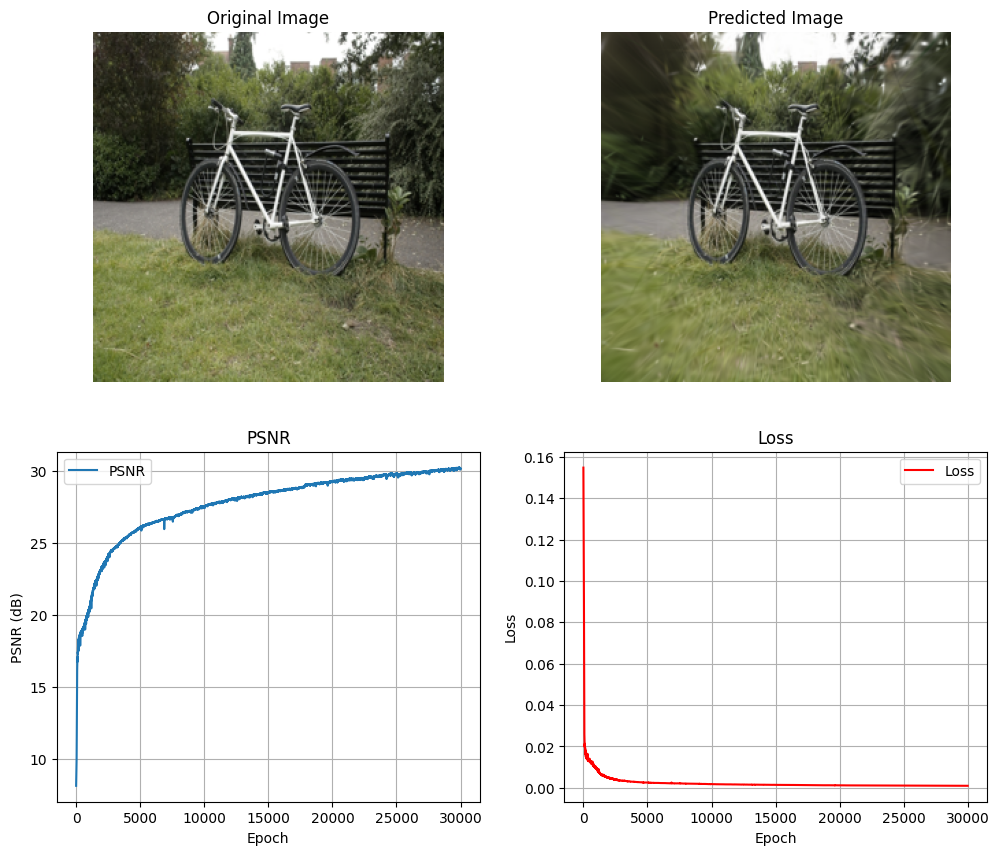

Iteration 29992/30000, Loss: 0.0009643161902204156, PSNR: 30.157804489135742
Iteration 29993/30000, Loss: 0.0009650771389715374, PSNR: 30.15437889099121
Iteration 29994/30000, Loss: 0.0009618869516998529, PSNR: 30.168758392333984
Iteration 29995/30000, Loss: 0.0009654139867052436, PSNR: 30.152862548828125
Iteration 29996/30000, Loss: 0.0009714834741316736, PSNR: 30.12564468383789
Iteration 29997/30000, Loss: 0.0009683184325695038, PSNR: 30.139816284179688
Iteration 29998/30000, Loss: 0.0009712340543046594, PSNR: 30.126760482788086
Iteration 29999/30000, Loss: 0.0009704012772999704, PSNR: 30.13048553466797
Iteration 30000/30000, Loss: 0.0009671429870650172, PSNR: 30.14509391784668
Saving checkpoint at: 29999
Total(s):
Rasterization: 206.515, Backward: 336.973
Per step(s):
Rasterization: 0.20651, Backward: 0.33697


In [25]:
# let's firstly train just basic 2d gaussian splats using mse loss
cfg = Config()
cfg.img_path = "/home/nskochetkov/sds_guided_3dgs/data/360_v2/bicycle/images_8/_DSC8679.JPG"
cfg.iterations = 30_000

if cfg.img_path:
    gt_image = image_path_to_tensor(cfg.img_path)
else:
    gt_image = torch.ones((cfg.height, cfg.width, 3)) * 1.0
    # make top left and bottom right red, blue
    gt_image[: cfg.height // 2, : cfg.width // 2, :] = torch.tensor([1.0, 0.0, 0.0])
    gt_image[cfg.height // 2 :, cfg.width // 2 :, :] = torch.tensor([0.0, 0.0, 1.0])

trainer = SimpleTrainer(
    gt_image=gt_image,
    cfg=cfg
)

trainer.train()

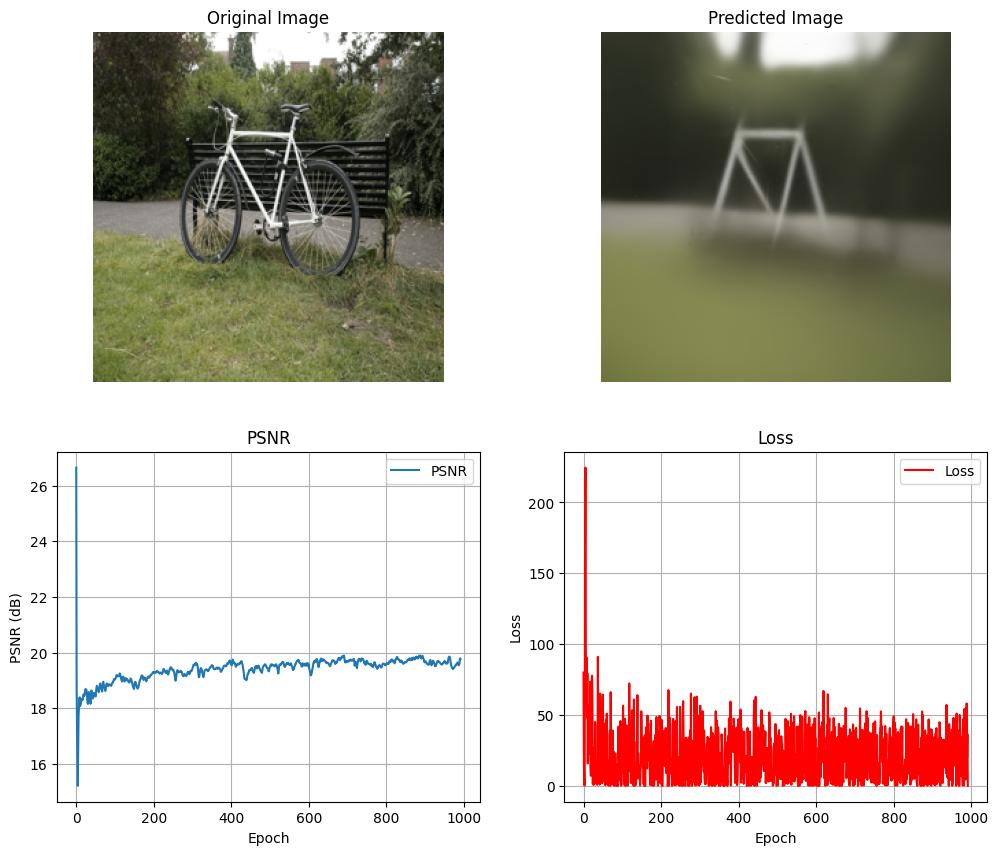

Iteration 7992/7999, Loss: 24.924373626708984, PSNR: 19.6916561126709
Iteration 7993/7999, Loss: 25.63489532470703, PSNR: 19.626550674438477
Iteration 7994/7999, Loss: 2.41849422454834, PSNR: 19.592920303344727
Iteration 7995/7999, Loss: 43.404335021972656, PSNR: 19.565998077392578
Iteration 7996/7999, Loss: 50.884422302246094, PSNR: 19.575302124023438
Iteration 7997/7999, Loss: 10.325785636901855, PSNR: 19.610788345336914
Iteration 7998/7999, Loss: 43.94922637939453, PSNR: 19.632749557495117
Iteration 7999/7999, Loss: 10.848104476928711, PSNR: 19.642969131469727
Saving checkpoint at: 7998
Total(s):
Rasterization: 4.240, Backward: 108.323
Per step(s):
Rasterization: 0.00424, Backward: 0.10832


In [41]:
# I
# now let's perform experiments with 7000 iterations with
# sds loss but without patches, learning rate will be 1e-6, much smaller then for basic splats learning
cfg = Config()
checkpoint_iters = 6999
cfg.img_path = "/home/nskochetkov/sds_guided_3dgs/data/360_v2/bicycle/images_8/_DSC8679.JPG"
cfg.ckpt_path = f"/home/nskochetkov/sds_guided_3dgs/results_2d/ckpts/ckpt_{checkpoint_iters}.pt"
cfg.iterations = 1_000
cfg.use_sds_loss = True
cfg.results_dir = f"results_2d_sds_without_patches_unfused_baseline_{checkpoint_iters}"
cfg.lr = 1e-6

if cfg.img_path:
    gt_image = image_path_to_tensor(cfg.img_path)
else:
    gt_image = torch.ones((cfg.height, cfg.width, 3)) * 1.0
    # make top left and bottom right red, blue
    gt_image[: cfg.height // 2, : cfg.width // 2, :] = torch.tensor([1.0, 0.0, 0.0])
    gt_image[cfg.height // 2 :, cfg.width // 2 :, :] = torch.tensor([0.0, 0.0, 1.0])

trainer = SimpleTrainer(
    gt_image=gt_image,
    cfg=cfg
)

trainer.train()

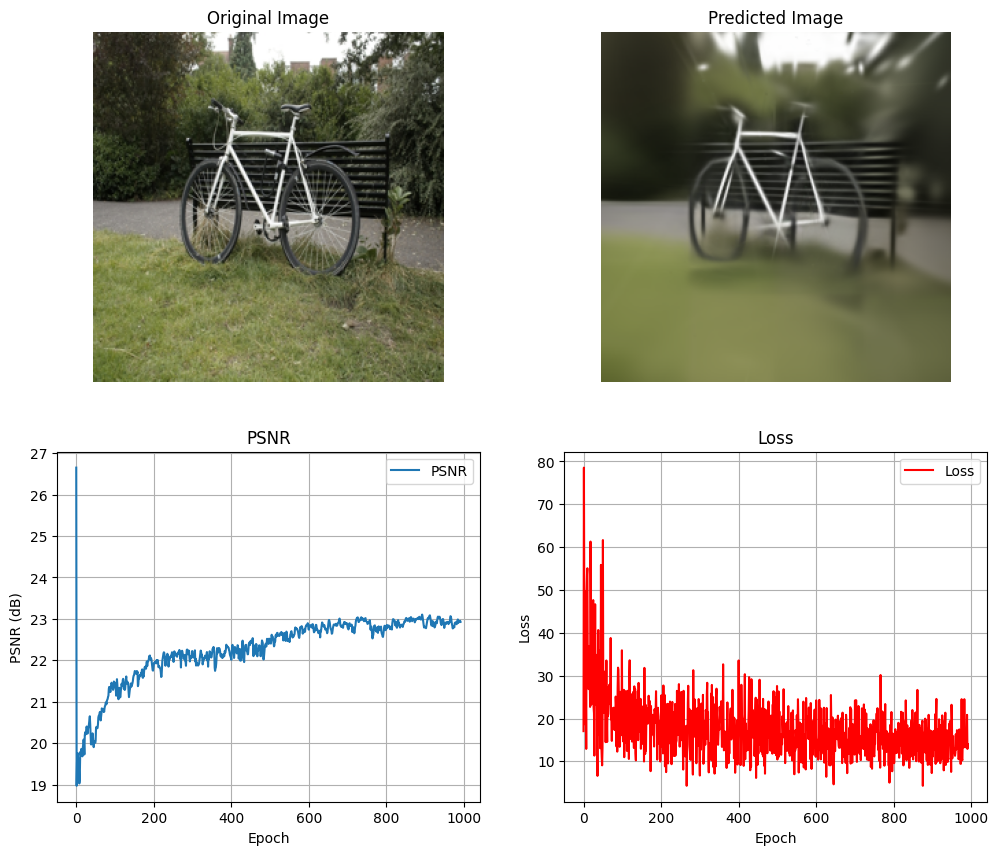

Iteration 7992/7999, Loss: 17.91155433654785, PSNR: 22.95277976989746
Iteration 7993/7999, Loss: 14.277752876281738, PSNR: 22.96430206298828
Iteration 7994/7999, Loss: 18.039274215698242, PSNR: 22.986900329589844
Iteration 7995/7999, Loss: 10.884997367858887, PSNR: 23.02930450439453
Iteration 7996/7999, Loss: 20.153297424316406, PSNR: 23.041149139404297
Iteration 7997/7999, Loss: 14.953246116638184, PSNR: 22.996192932128906
Iteration 7998/7999, Loss: 19.39122772216797, PSNR: 23.024600982666016
Iteration 7999/7999, Loss: 17.66350555419922, PSNR: 23.018198013305664
Saving checkpoint at: 7998
Total(s):
Rasterization: 5.104, Backward: 1472.888
Per step(s):
Rasterization: 0.00510, Backward: 1.47289


In [42]:
# II
# now let's perform experiments with 7000 iterations with
# sds loss with patches learning rate will be 1e-6, much smaller then for basic splats learning
cfg = Config()
checkpoint_iters = 6999
cfg.img_path = "/home/nskochetkov/sds_guided_3dgs/data/360_v2/bicycle/images_8/_DSC8679.JPG"
cfg.ckpt_path = f"/home/nskochetkov/sds_guided_3dgs/results_2d/ckpts/ckpt_{checkpoint_iters}.pt"
cfg.iterations = 1_000
cfg.use_sds_loss = True
cfg.patch_image = True
cfg.results_dir = f"results_2d_sds_patched_unfused_baseline_{checkpoint_iters}"
cfg.lr = 1e-6

if cfg.img_path:
    gt_image = image_path_to_tensor(cfg.img_path)
else:
    gt_image = torch.ones((cfg.height, cfg.width, 3)) * 1.0
    # make top left and bottom right red, blue
    gt_image[: cfg.height // 2, : cfg.width // 2, :] = torch.tensor([1.0, 0.0, 0.0])
    gt_image[cfg.height // 2 :, cfg.width // 2 :, :] = torch.tensor([0.0, 0.0, 1.0])

trainer = SimpleTrainer(
    gt_image=gt_image,
    cfg=cfg
)

trainer.train()

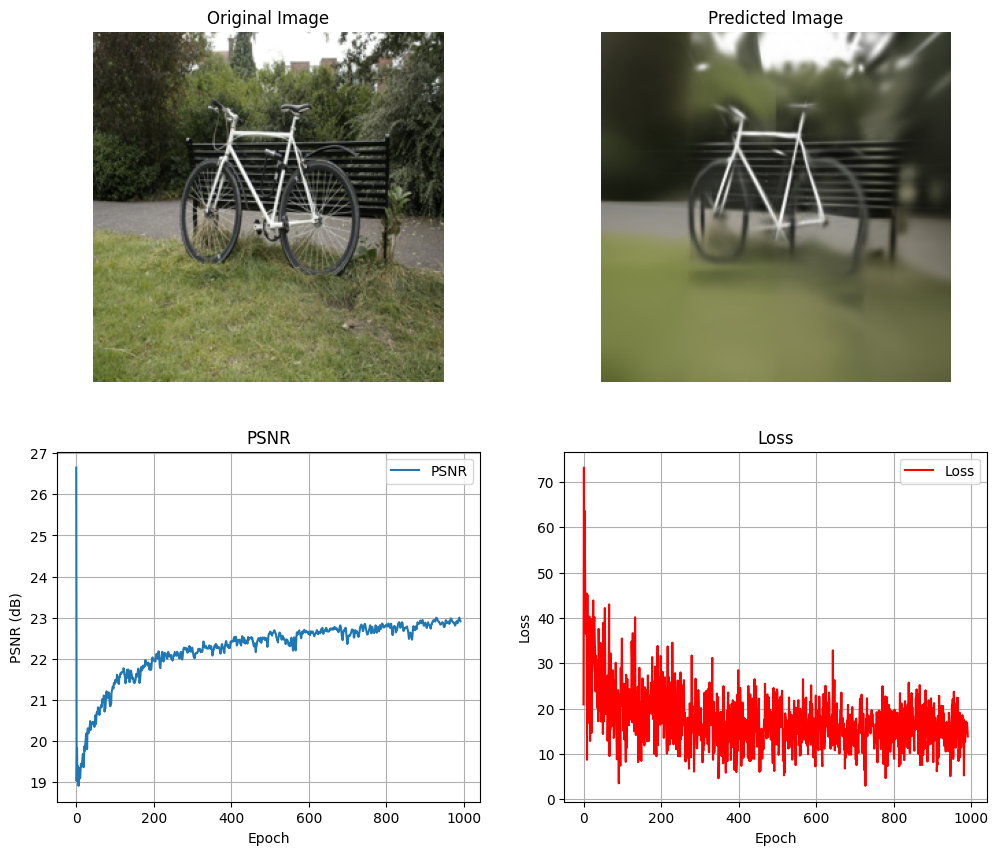

Iteration 7992/7999, Loss: 16.659282684326172, PSNR: 22.904157638549805
Iteration 7993/7999, Loss: 16.615856170654297, PSNR: 22.931121826171875
Iteration 7994/7999, Loss: 13.321188926696777, PSNR: 22.954862594604492
Iteration 7995/7999, Loss: 14.711697578430176, PSNR: 22.94146728515625
Iteration 7996/7999, Loss: 14.674880981445312, PSNR: 22.934213638305664
Iteration 7997/7999, Loss: 16.18543815612793, PSNR: 22.91252899169922
Iteration 7998/7999, Loss: 11.117733001708984, PSNR: 22.948177337646484
Iteration 7999/7999, Loss: 18.144535064697266, PSNR: 22.970266342163086
Saving checkpoint at: 7998
Total(s):
Rasterization: 5.035, Backward: 1473.266
Per step(s):
Rasterization: 0.00504, Backward: 1.47327


In [43]:
# III
# now let's perform experiments with 7000 iterations with
# sds loss with patches learning rate will be 1e-6, much smaller then for basic splats learning
cfg = Config()
checkpoint_iters = 6999
cfg.img_path = "/home/nskochetkov/sds_guided_3dgs/data/360_v2/bicycle/images_8/_DSC8679.JPG"
cfg.ckpt_path = f"/home/nskochetkov/sds_guided_3dgs/results_2d/ckpts/ckpt_{checkpoint_iters}.pt"
cfg.iterations = 1_000
cfg.use_sds_loss = True
cfg.patch_image = True
cfg.use_fused_loss = True
cfg.results_dir = f"results_2d_sds_patched_fused_baseline_{checkpoint_iters}"
cfg.lr = 1e-6

if cfg.img_path:
    gt_image = image_path_to_tensor(cfg.img_path)
else:
    gt_image = torch.ones((cfg.height, cfg.width, 3)) * 1.0
    # make top left and bottom right red, blue
    gt_image[: cfg.height // 2, : cfg.width // 2, :] = torch.tensor([1.0, 0.0, 0.0])
    gt_image[cfg.height // 2 :, cfg.width // 2 :, :] = torch.tensor([0.0, 0.0, 1.0])

trainer = SimpleTrainer(
    gt_image=gt_image,
    cfg=cfg
)

trainer.train()

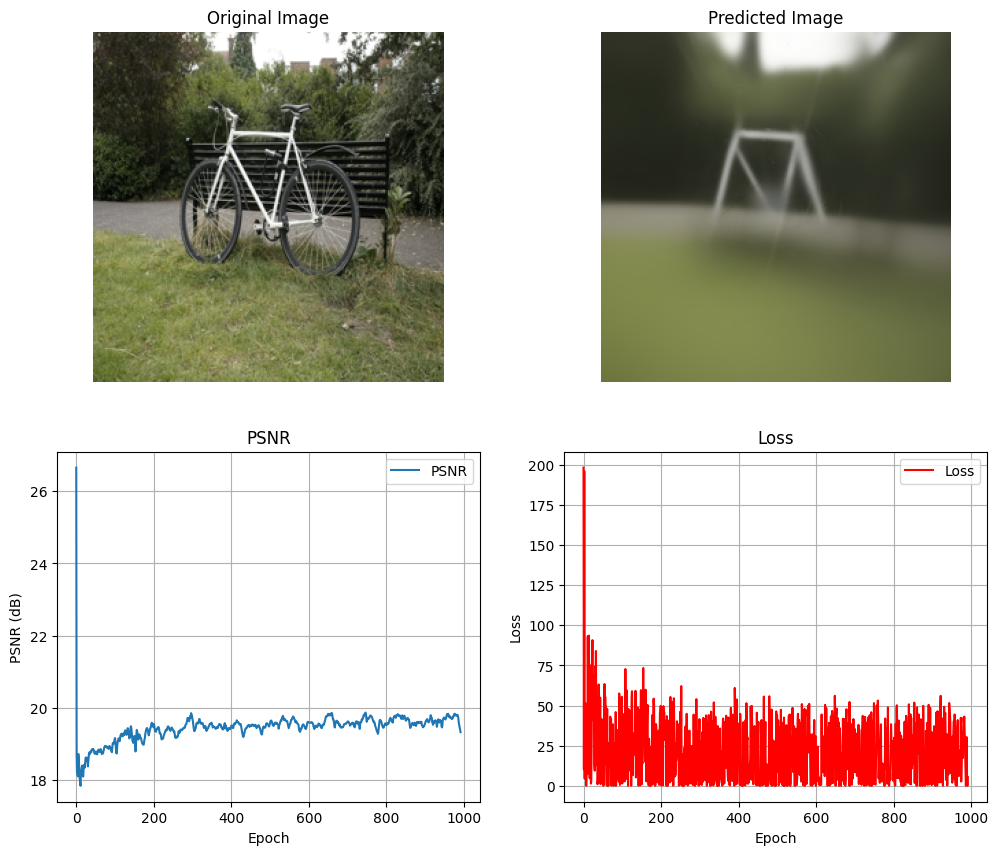

Iteration 7992/7999, Loss: 1.289363145828247, PSNR: 19.292831420898438
Iteration 7993/7999, Loss: 6.185202598571777, PSNR: 19.2692813873291
Iteration 7994/7999, Loss: 22.60155487060547, PSNR: 19.29499626159668
Iteration 7995/7999, Loss: 33.40565490722656, PSNR: 19.339176177978516
Iteration 7996/7999, Loss: 23.483537673950195, PSNR: 19.40182113647461
Iteration 7997/7999, Loss: 2.3907241821289062, PSNR: 19.500694274902344
Iteration 7998/7999, Loss: 16.02859878540039, PSNR: 19.544797897338867
Iteration 7999/7999, Loss: 20.14893341064453, PSNR: 19.55830192565918
Saving checkpoint at: 7998
Total(s):
Rasterization: 4.127, Backward: 107.984
Per step(s):
Rasterization: 0.00413, Backward: 0.10798


In [44]:
# IIII
# now let's perform experiments with 7000 iterations with
# sds loss but without patches, learning rate will be 1e-6, much smaller then for basic splats learning
cfg = Config()
checkpoint_iters = 6999
cfg.img_path = "/home/nskochetkov/sds_guided_3dgs/data/360_v2/bicycle/images_8/_DSC8679.JPG"
cfg.ckpt_path = f"/home/nskochetkov/sds_guided_3dgs/results_2d/ckpts/ckpt_{checkpoint_iters}.pt"
cfg.iterations = 1_000
cfg.use_sds_loss = True
cfg.use_fused_loss = True
cfg.results_dir = f"results_2d_sds_without_patches_fused_baseline_{checkpoint_iters}"
cfg.lr = 1e-6

if cfg.img_path:
    gt_image = image_path_to_tensor(cfg.img_path)
else:
    gt_image = torch.ones((cfg.height, cfg.width, 3)) * 1.0
    # make top left and bottom right red, blue
    gt_image[: cfg.height // 2, : cfg.width // 2, :] = torch.tensor([1.0, 0.0, 0.0])
    gt_image[cfg.height // 2 :, cfg.width // 2 :, :] = torch.tensor([0.0, 0.0, 1.0])

trainer = SimpleTrainer(
    gt_image=gt_image,
    cfg=cfg
)

trainer.train()

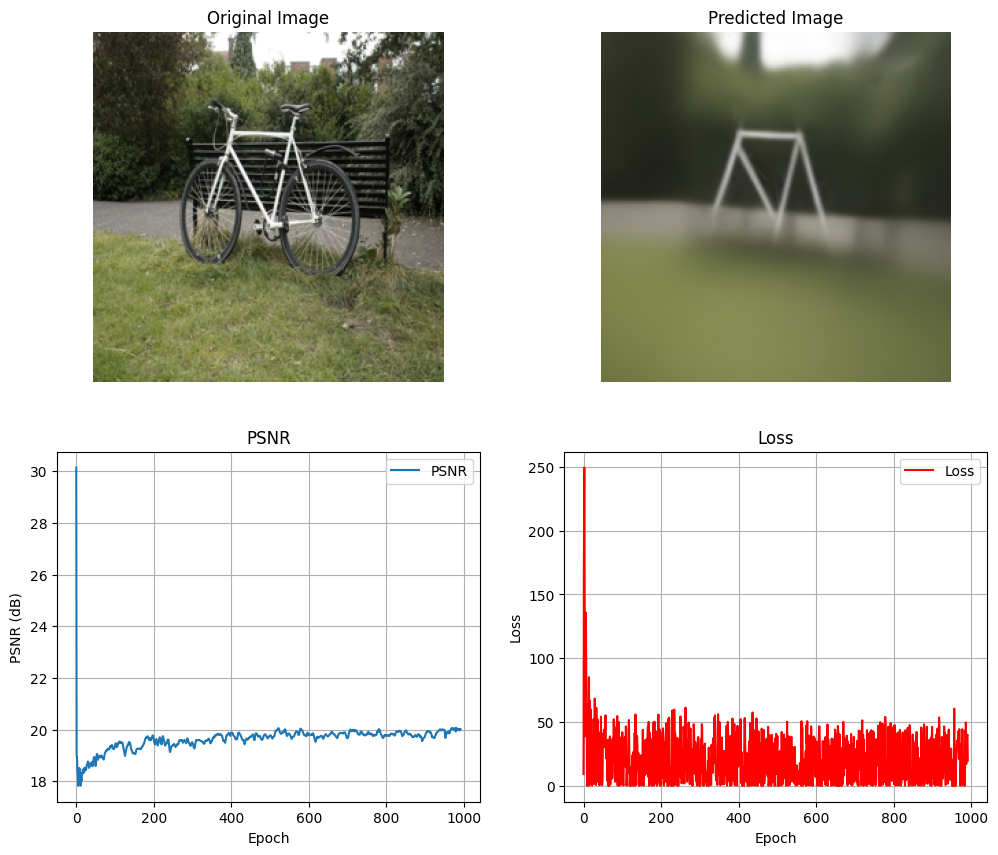

Iteration 30992/30999, Loss: 0.5674254298210144, PSNR: 20.0244197845459
Iteration 30993/30999, Loss: 0.08305348455905914, PSNR: 20.001447677612305
Iteration 30994/30999, Loss: 24.082046508789062, PSNR: 19.961307525634766
Iteration 30995/30999, Loss: 46.583518981933594, PSNR: 19.965229034423828
Iteration 30996/30999, Loss: 18.617338180541992, PSNR: 20.026447296142578
Iteration 30997/30999, Loss: 14.202120780944824, PSNR: 19.993968963623047
Iteration 30998/30999, Loss: 17.04423713684082, PSNR: 19.97539520263672
Iteration 30999/30999, Loss: 45.275245666503906, PSNR: 19.977670669555664
Saving checkpoint at: 30998
Total(s):
Rasterization: 2.248, Backward: 107.150
Per step(s):
Rasterization: 0.00225, Backward: 0.10715


In [45]:
# I
# now let's perform experiments with 7000 iterations with
# sds loss but without patches, learning rate will be 1e-6, much smaller then for basic splats learning
cfg = Config()
checkpoint_iters = 29999
cfg.img_path = "/home/nskochetkov/sds_guided_3dgs/data/360_v2/bicycle/images_8/_DSC8679.JPG"
cfg.ckpt_path = f"/home/nskochetkov/sds_guided_3dgs/results_2d/ckpts/ckpt_{checkpoint_iters}.pt"
cfg.iterations = 1_000
cfg.use_sds_loss = True
cfg.results_dir = f"results_2d_sds_without_patches_unfused_baseline_{checkpoint_iters}"
cfg.lr = 1e-6

if cfg.img_path:
    gt_image = image_path_to_tensor(cfg.img_path)
else:
    gt_image = torch.ones((cfg.height, cfg.width, 3)) * 1.0
    # make top left and bottom right red, blue
    gt_image[: cfg.height // 2, : cfg.width // 2, :] = torch.tensor([1.0, 0.0, 0.0])
    gt_image[cfg.height // 2 :, cfg.width // 2 :, :] = torch.tensor([0.0, 0.0, 1.0])

trainer = SimpleTrainer(
    gt_image=gt_image,
    cfg=cfg
)

trainer.train()

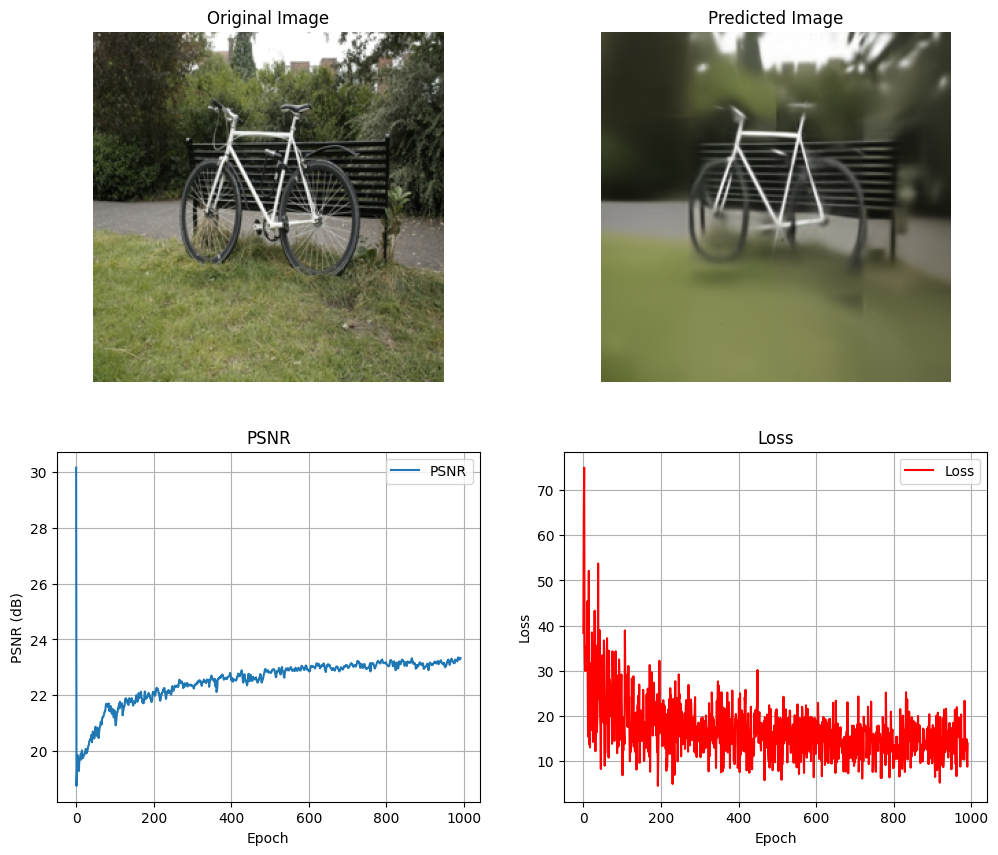

Iteration 30992/30999, Loss: 16.11492919921875, PSNR: 23.33969497680664
Iteration 30993/30999, Loss: 13.105746269226074, PSNR: 23.34320640563965
Iteration 30994/30999, Loss: 6.514063835144043, PSNR: 23.31780433654785
Iteration 30995/30999, Loss: 8.837989807128906, PSNR: 23.251251220703125
Iteration 30996/30999, Loss: 9.308135032653809, PSNR: 23.187747955322266
Iteration 30997/30999, Loss: 13.520181655883789, PSNR: 23.13680648803711
Iteration 30998/30999, Loss: 10.756032943725586, PSNR: 23.13897705078125
Iteration 30999/30999, Loss: 11.78337287902832, PSNR: 23.116989135742188
Saving checkpoint at: 30998
Total(s):
Rasterization: 3.223, Backward: 1472.388
Per step(s):
Rasterization: 0.00322, Backward: 1.47239


In [46]:
# II
# now let's perform experiments with 7000 iterations with
# sds loss with patches learning rate will be 1e-6, much smaller then for basic splats learning
cfg = Config()
checkpoint_iters = 29999
cfg.img_path = "/home/nskochetkov/sds_guided_3dgs/data/360_v2/bicycle/images_8/_DSC8679.JPG"
cfg.ckpt_path = f"/home/nskochetkov/sds_guided_3dgs/results_2d/ckpts/ckpt_{checkpoint_iters}.pt"
cfg.iterations = 1_000
cfg.use_sds_loss = True
cfg.patch_image = True
cfg.results_dir = f"results_2d_sds_patched_unfused_baseline_{checkpoint_iters}"
cfg.lr = 1e-6

if cfg.img_path:
    gt_image = image_path_to_tensor(cfg.img_path)
else:
    gt_image = torch.ones((cfg.height, cfg.width, 3)) * 1.0
    # make top left and bottom right red, blue
    gt_image[: cfg.height // 2, : cfg.width // 2, :] = torch.tensor([1.0, 0.0, 0.0])
    gt_image[cfg.height // 2 :, cfg.width // 2 :, :] = torch.tensor([0.0, 0.0, 1.0])

trainer = SimpleTrainer(
    gt_image=gt_image,
    cfg=cfg
)

trainer.train()

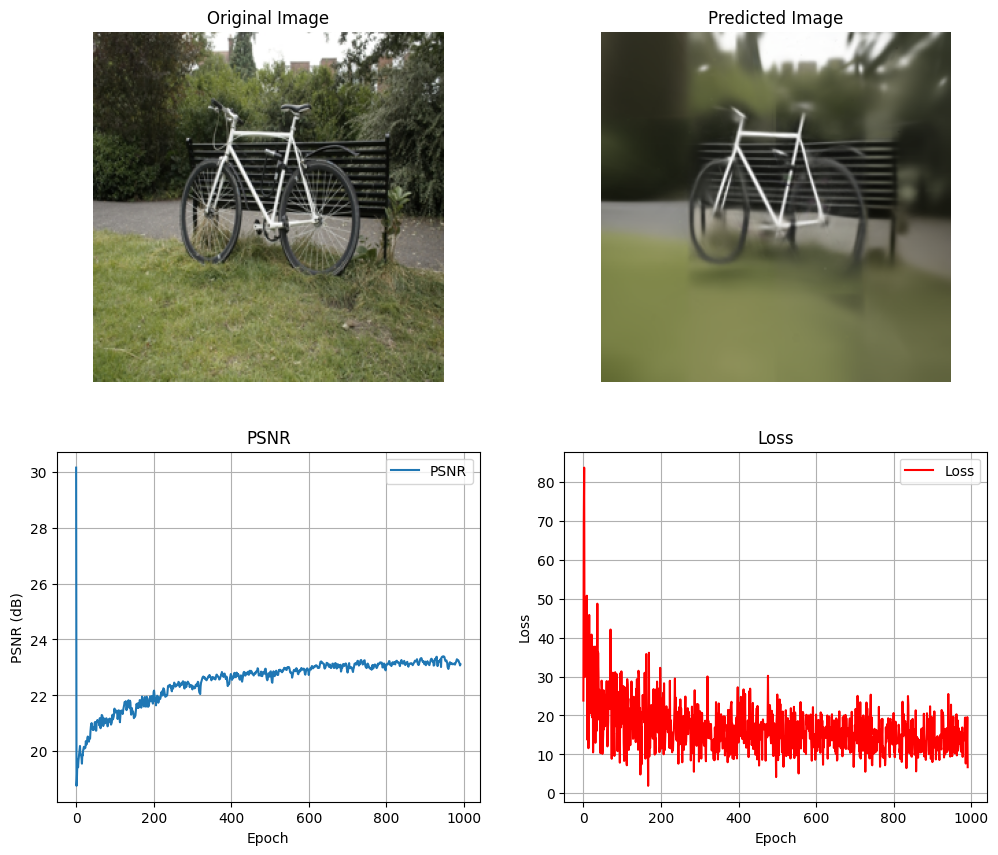

Iteration 30992/30999, Loss: 15.918384552001953, PSNR: 23.118207931518555
Iteration 30993/30999, Loss: 10.19902515411377, PSNR: 23.128787994384766
Iteration 30994/30999, Loss: 14.88439655303955, PSNR: 23.124122619628906
Iteration 30995/30999, Loss: 17.83894157409668, PSNR: 23.166391372680664
Iteration 30996/30999, Loss: 17.635923385620117, PSNR: 23.238746643066406
Iteration 30997/30999, Loss: 13.059314727783203, PSNR: 23.125192642211914
Iteration 30998/30999, Loss: 18.107202529907227, PSNR: 23.15605354309082
Iteration 30999/30999, Loss: 18.500642776489258, PSNR: 23.235551834106445
Saving checkpoint at: 30998
Total(s):
Rasterization: 3.296, Backward: 1472.261
Per step(s):
Rasterization: 0.00330, Backward: 1.47226


In [47]:
# III
# now let's perform experiments with 7000 iterations with
# sds loss with patches learning rate will be 1e-6, much smaller then for basic splats learning
cfg = Config()
checkpoint_iters = 29999
cfg.img_path = "/home/nskochetkov/sds_guided_3dgs/data/360_v2/bicycle/images_8/_DSC8679.JPG"
cfg.ckpt_path = f"/home/nskochetkov/sds_guided_3dgs/results_2d/ckpts/ckpt_{checkpoint_iters}.pt"
cfg.iterations = 1_000
cfg.use_sds_loss = True
cfg.patch_image = True
cfg.use_fused_loss = True
cfg.results_dir = f"results_2d_sds_patched_fused_baseline_{checkpoint_iters}"
cfg.lr = 1e-6

if cfg.img_path:
    gt_image = image_path_to_tensor(cfg.img_path)
else:
    gt_image = torch.ones((cfg.height, cfg.width, 3)) * 1.0
    # make top left and bottom right red, blue
    gt_image[: cfg.height // 2, : cfg.width // 2, :] = torch.tensor([1.0, 0.0, 0.0])
    gt_image[cfg.height // 2 :, cfg.width // 2 :, :] = torch.tensor([0.0, 0.0, 1.0])

trainer = SimpleTrainer(
    gt_image=gt_image,
    cfg=cfg
)

trainer.train()

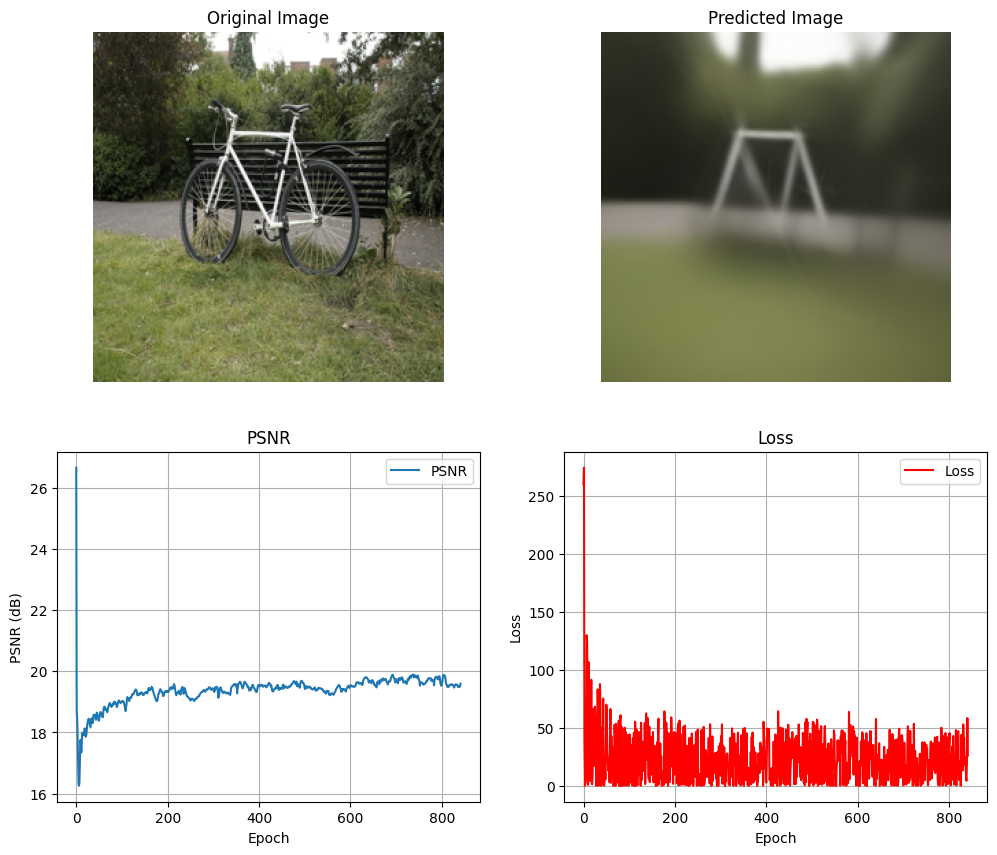

Iteration 7842/7999, Loss: 37.768455505371094, PSNR: 19.648141860961914
Iteration 7843/7999, Loss: 9.240427017211914, PSNR: 19.675457000732422
Iteration 7844/7999, Loss: 9.6797513961792, PSNR: 19.71677017211914
Iteration 7845/7999, Loss: 0.3557000160217285, PSNR: 19.74332046508789
Iteration 7846/7999, Loss: 36.97356033325195, PSNR: 19.72720718383789
Iteration 7847/7999, Loss: 42.37281036376953, PSNR: 19.745376586914062
Iteration 7848/7999, Loss: 47.60966491699219, PSNR: 19.739540100097656
Iteration 7849/7999, Loss: 33.15800476074219, PSNR: 19.74562644958496
Iteration 7850/7999, Loss: 44.39542770385742, PSNR: 19.739036560058594
Iteration 7851/7999, Loss: 34.647056579589844, PSNR: 19.756214141845703


In [ ]:
# IIII
# now let's perform experiments with 7000 iterations with
# sds loss but without patches, learning rate will be 1e-6, much smaller then for basic splats learning
cfg = Config()
checkpoint_iters = 6999
cfg.img_path = "/home/nskochetkov/sds_guided_3dgs/data/360_v2/bicycle/images_8/_DSC8679.JPG"
cfg.ckpt_path = f"/home/nskochetkov/sds_guided_3dgs/results_2d/ckpts/ckpt_{checkpoint_iters}.pt"
cfg.iterations = 1_000
cfg.use_sds_loss = True
cfg.use_fused_loss = True
cfg.results_dir = f"results_2d_sds_without_patches_fused_baseline_{checkpoint_iters}"
cfg.lr = 1e-6

if cfg.img_path:
    gt_image = image_path_to_tensor(cfg.img_path)
else:
    gt_image = torch.ones((cfg.height, cfg.width, 3)) * 1.0
    # make top left and bottom right red, blue
    gt_image[: cfg.height // 2, : cfg.width // 2, :] = torch.tensor([1.0, 0.0, 0.0])
    gt_image[cfg.height // 2 :, cfg.width // 2 :, :] = torch.tensor([0.0, 0.0, 1.0])

trainer = SimpleTrainer(
    gt_image=gt_image,
    cfg=cfg
)

trainer.train()

In [ ]:
! gcc --version